In [22]:
import numpy as np
import os
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
import umap
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as mc

## turn off warning
import warnings
warnings.filterwarnings("ignore")

## generating the list of datasets
datasets = []
for directory in os.listdir("./labeled-datasets/npy/"):
	if (
		directory != ".DS_Store"
		and directory != "README.md"
		and directory != ".gitignore"
		and not directory.endswith(".zip")
	):
		datasets.append(directory)

### Dataset (Embedding) Generation

In [12]:
for dataset in tqdm(datasets):
	raw = np.load(f"./labeled-datasets/npy/{dataset}/data.npy")
	umap_emb = umap.UMAP(n_components=2).fit_transform(raw)
	tsne_emb = TSNE(n_components=2).fit_transform(raw)
	pca_emb = PCA(n_components=2).fit_transform(raw)
	random_emb = SparseRandomProjection(n_components=2).fit_transform(raw)

	## if the directory does not exists, make it
	if not os.path.exists(f"./labeled-datasets_embedding/{dataset}"):
		os.makedirs(f"./labeled-datasets_embedding/{dataset}")
	
	np.save(f"./labeled-datasets_embedding/{dataset}/umap.npy", umap_emb)
	np.save(f"./labeled-datasets_embedding/{dataset}/tsne.npy", tsne_emb)
	np.save(f"./labeled-datasets_embedding/{dataset}/pca.npy", pca_emb)
	np.save(f"./labeled-datasets_embedding/{dataset}/random.npy", random_emb)


100%|██████████| 96/96 [33:07<00:00, 20.70s/it] 


### Running scalability exp => check `scalability_exp.py`

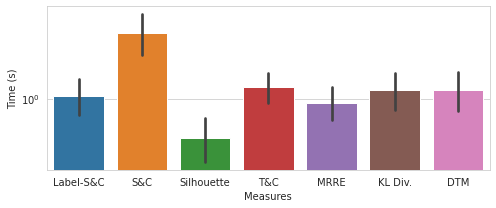

In [18]:
dr_measures = ["lsnc_btw_ch", "snc", "silhouette", "tnc", "mrre", "kl_div", "dtm"]
dr_measures_name = ["Label-S&C", "S&C", "Silhouette", "T&C", "MRRE", "KL Div.", "DTM"]

## generating pandas dataframe that holds the results
results_df = pd.DataFrame({
	"measure": [],
	"time": [],
})
for dr_measure in dr_measures:
	dr_measure_time = np.load(f"./scalability_results/{dr_measure}_time.npy")
	results_df = results_df.append(pd.DataFrame({
		"measure": [dr_measure] * len(dr_measure_time),
		"time": dr_measure_time,
	}), ignore_index = True)

## plotting the results using boxplot (seaborn)
plt.figure(figsize = (7, 3))

sns.set_style("whitegrid")

sns.barplot(x = "measure", y = "time", data = results_df)
plt.yscale("log")
plt.xticks(range(len(dr_measures)), dr_measures_name)
plt.xlabel("Measures")
plt.ylabel("Time (s)")

plt.tight_layout()

plt.savefig("./plot/scalability.pdf", dpi=300)

### Statistical test

In [24]:

model = ols("time ~ C(measure)", data = results_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

## perform tukeyhsd  (multiple comparison)
mc_results = mc.MultiComparison(results_df["time"], results_df["measure"])
mc_results_results = mc_results.tukeyhsd()
print(mc_results_results)


                  sum_sq      df          F        PR(>F)
C(measure)   1077.416509     6.0  10.563736  1.275699e-11
Residual    45573.423668  2681.0        NaN           NaN
     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj   lower   upper  reject
--------------------------------------------------------------
        dtm      kl_div   0.0055    1.0 -0.8724  0.8835  False
        dtm lsnc_btw_ch  -0.0927 0.9999 -0.9706  0.7853  False
        dtm        mrre  -0.1966 0.9946 -1.0745  0.6814  False
        dtm  silhouette  -0.5875 0.4312 -1.4655  0.2904  False
        dtm         snc   1.5792    0.0  0.7013  2.4572   True
        dtm         tnc   0.0601    1.0 -0.8179   0.938  False
     kl_div lsnc_btw_ch  -0.0982 0.9999 -0.9761  0.7797  False
     kl_div        mrre  -0.2021 0.9937   -1.08  0.6758  False
     kl_div  silhouette  -0.5931 0.4192  -1.471  0.2849  False
     kl_div         snc   1.5737    0.0  0.6958  2.4516   True
     kl